SECTION 1: IMPORTING LIBS AND SETTING UP

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility and consistency
np.random.seed(42)
tf.random.set_seed(42)

In [75]:
# Check Tensorflow Version and GPU availability

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.10.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


SECTION 2: CONFIGURATION

In [76]:
# Dataset config.
DATASET_PATH = '../asl_dataset'
IMG_SIZE = 64  
BATCH_SIZE = 32
NUM_CLASSES = 36  # A-Z (26) + 0-9 (10)

In [77]:
# Training config.
MAX_EPOCHS = 100
DROPOUT_RATE = 0.4

In [78]:
def get_class_names_from_dataset(dataset_path):

    class_names = [f for f in os.listdir(dataset_path) 
                   if os.path.isdir(os.path.join(dataset_path, f))]
    
    digits = sorted([c for c in class_names if c.isdigit()])
    letters = sorted([c for c in class_names if c.isalpha()])
    
    return digits + letters

CLASS_NAMES = get_class_names_from_dataset(DATASET_PATH)
print(f"Classes: {CLASS_NAMES}")
print(f"Number of classes: {len(CLASS_NAMES)}")

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Number of classes: 36


SECTION 3: DATA LOADING

In [79]:
def load_dataset(dataset_path, img_size):
    images = []
    labels = []
    class_counts = {}
    
    print("Loading dataset...")
    
    # Iterate through each class folder
    for class_idx, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(dataset_path, class_name)
        
        if not os.path.exists(class_path):
            print(f"Warning: Folder '{class_name}' not found!")
            continue
        
        # Load all images in this class folder
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        class_counts[class_name] = len(image_files)
        
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            
            # Read image
            img = cv2.imread(img_path)
            
            if img is None:
                print(f"Warning: Could not read {img_path}")
                continue
            
            # Convert BGR to RGB as OpenCV lib loads as BGR
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Resize to target size
            img = cv2.resize(img, (img_size, img_size))
            
            images.append(img)
            labels.append(class_idx)
    
    # Convert to numpy arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels)
    
    print(f"\nDataset loaded successfully!")
    print(f"Total images: {len(images)}")
    print(f"Image shape: {images[0].shape}")
    print(f"\nClass distribution:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} images")
    
    return images, labels, class_counts

# Load the dataset
X, y, class_distribution = load_dataset(DATASET_PATH, IMG_SIZE)


Loading dataset...

Dataset loaded successfully!
Total images: 7200
Image shape: (64, 64, 3)

Class distribution:
  0: 200 images
  1: 200 images
  2: 200 images
  3: 200 images
  4: 200 images
  5: 200 images
  6: 200 images
  7: 200 images
  8: 200 images
  9: 200 images
  A: 200 images
  B: 200 images
  C: 200 images
  D: 200 images
  E: 200 images
  F: 200 images
  G: 200 images
  H: 200 images
  I: 200 images
  J: 200 images
  K: 200 images
  L: 200 images
  M: 200 images
  N: 200 images
  O: 200 images
  P: 200 images
  Q: 200 images
  R: 200 images
  S: 200 images
  T: 200 images
  U: 200 images
  V: 200 images
  W: 200 images
  X: 200 images
  Y: 200 images
  Z: 200 images


SECTION 4: DATA VISUALIZATION

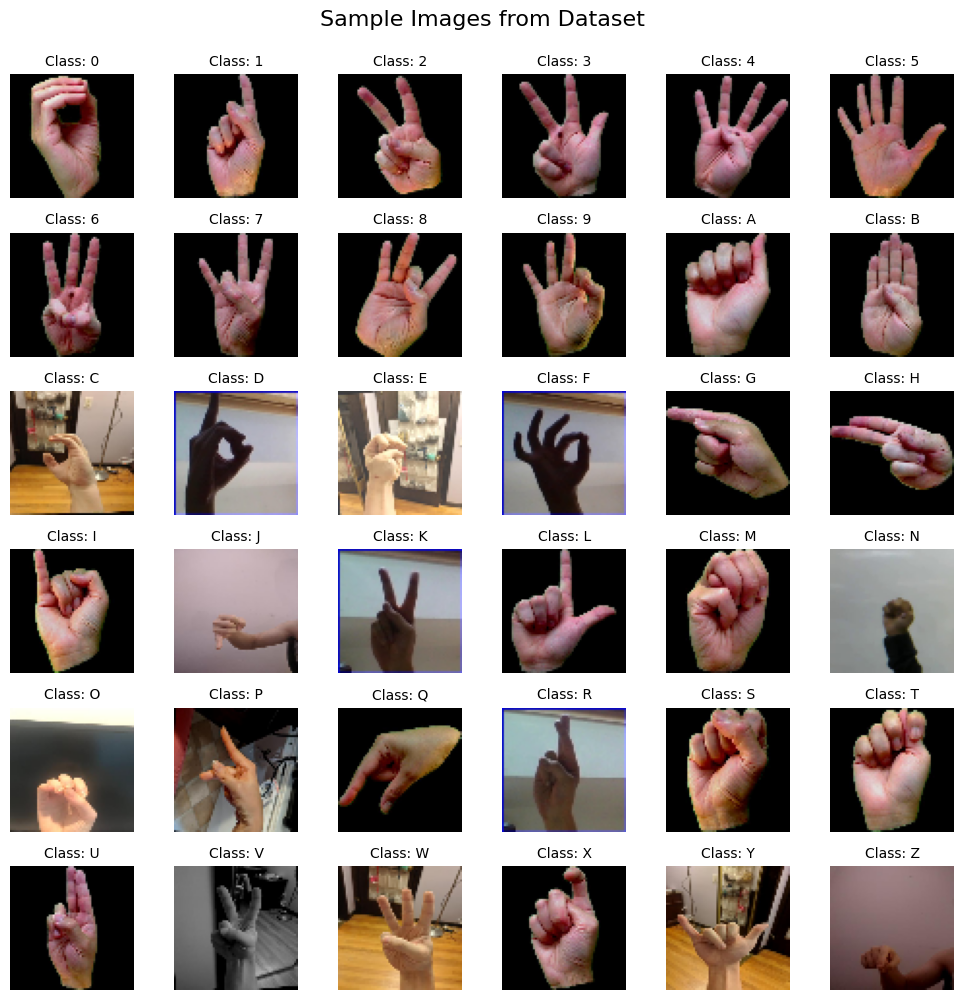

In [82]:
# Visualize sample images from each class
def visualize_samples(images, labels, class_names, samples_per_class=5):
    fig, axes = plt.subplots(6, 6, figsize=(10, 10)) # rhe original was 15, 15 figsize
    fig.suptitle('Sample Images from Dataset', fontsize=16, y=0.995)
    
    for idx, class_idx in enumerate(range(min(36, len(class_names)))):
        class_images = images[labels == class_idx]
        
        if len(class_images) > 0:
            # Pick a random sample
            sample_img = class_images[np.random.randint(0, len(class_images))]
            
            row = idx // 6
            col = idx % 6
            
            axes[row, col].imshow(sample_img.astype('uint8'))
            axes[row, col].set_title(f'Class: {class_names[class_idx]}', fontsize=10)
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
visualize_samples(X, y, CLASS_NAMES)

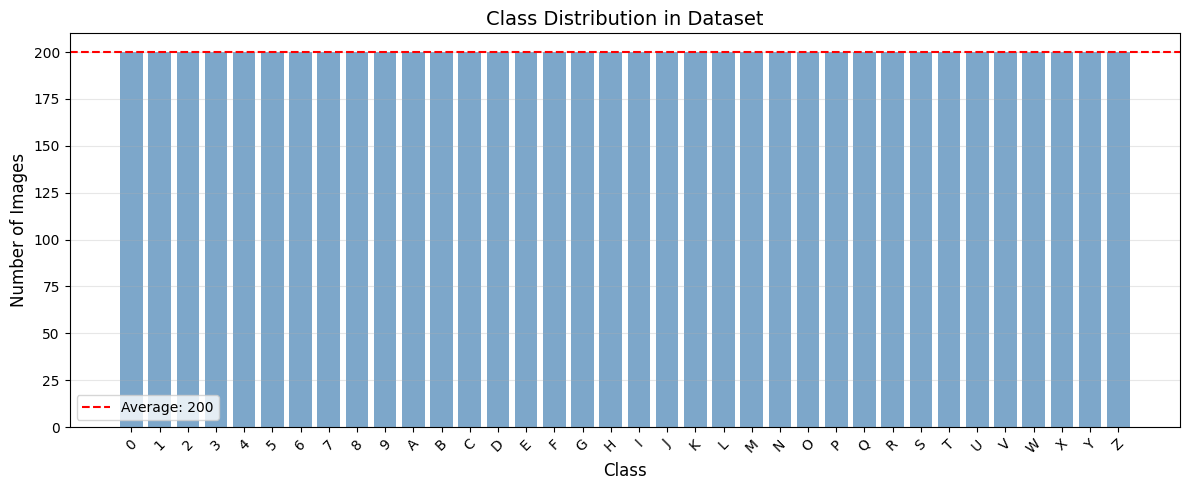


Class Balance Analysis:
a. Min images per class: 200
b. Max images per class: 200
c. Imbalance ratio: 1.00
🌱 Dataset is reasonably balanced.


In [83]:
# Plot the distribution of the image across classes
def plot_class_distribution(class_counts):
    plt.figure(figsize=(12, 5))
    
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.bar(classes, counts, color='steelblue', alpha=0.7)
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.title('Class Distribution in Dataset', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    # Add average line
    avg_count = np.mean(counts)
    plt.axhline(y=avg_count, color='red', linestyle='--', 
                label=f'Average: {avg_count:.0f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Check for imbalance
    min_count = min(counts)
    max_count = max(counts)
    imbalance_ratio = max_count / min_count
    
    print(f"\nClass Balance Analysis:")
    print(f"a. Min images per class: {min_count}")
    print(f"b. Max images per class: {max_count}")
    print(f"c. Imbalance ratio: {imbalance_ratio:.2f}")
    
    if imbalance_ratio > 2:
        print("⚠️ Warning: Significant class imbalance detected!")
    else:
        print("🌱 Dataset is reasonably balanced.")


plot_class_distribution(class_distribution)

SECTION 5: DATA PREPROCESSING AND SLITTING

In [84]:
# Scalling pixel value from [0, 255] to [0,1] 
X = X / 255.0 
print(f"Image value range after normalization: [{X.min():.2f}, {X.max():.2f}]")

Image value range after normalization: [0.00, 1.00]


In [85]:
# Splitting: 80% train, 10% validation, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {len(X_train)} images ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} images ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} images ({len(X_test)/len(X)*100:.1f}%)")

Training set: 5760 images (80.0%)
Validation set: 720 images (10.0%)
Test set: 720 images (10.0%)


In [86]:
# Converting labels to categorical using one-hot encoding
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_val_cat = to_categorical(y_val, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

In [ ]:
# Data Augmentation

# train_datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     shear_range=0.1,
#     horizontal_flip = False,
#     fill_mode='nearest'
# )

#def show_augmentation(images, labels, datagen, n_samples=9):
#     fig, axes = plt.subplots(3, 3, figsize=(10, 10))
#     fig.suptitle('Data Augmentation Examples', fontsize=14)
#     
#     idx = np.random.randint(0, len(images))
#     img = images[idx]
#     label = CLASS_NAMES[labels[idx]]
#     
#     for i in range(9):
#         img_aug = datagen.random_transform(img)
#         
#         row = i // 3
#         col = i % 3
#         
#         axes[row, col].imshow(img_aug)
#         axes[row, col].set_title(f'{label} (augmented)', fontsize=10)
#         axes[row, col].axis('off')
#     
#     plt.tight_layout()
#     plt.show()

# show_augmentation(X_train, y_train, train_datagen)

SECTION 6: CNN MODEL ARCHITECTURE

In [ ]:
def build_cnn_model(input_shape, num_classes, dropout_rate=0.4):
    """
    Note: 
    Conv Block 1: 32 filters
    Conv Block 2: 64 filters
    Conv Block 3: 128 filters . 
    Dense layers: 256 -> 128 -> num_classes
    """
    model = models.Sequential(name='ASL_CNN')
    
    # BLOCK 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same', name='conv1_1'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool1'))
    model.add(layers.Dropout(0.25, name='dropout1'))
    
    # BLOCK 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_1'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool2'))
    model.add(layers.Dropout(0.25, name='dropout2'))
    
    # BLOCK 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'))
    model.add(layers.MaxPooling2D((2, 2), name='pool3'))
    model.add(layers.Dropout(dropout_rate, name='dropout3'))
    
    # DENSE LAYER
    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Dense(256, activation='relu', name='dense1'))
    model.add(layers.Dropout(0.5, name='dropout4'))
    model.add(layers.Dense(128, activation='relu', name='dense2'))
    model.add(layers.Dropout(0.5, name='dropout5'))
    model.add(layers.Dense(num_classes, activation='softmax', name='output'))
    
    return model

In [89]:
# BUILD THE MODEL
model = build_cnn_model(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    num_classes=NUM_CLASSES,
    dropout_rate=DROPOUT_RATE
)

# Display model architecture
model.summary()

# Count parameters
total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")

Model: "ASL_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 64, 64, 32)        896       
                                                                 
 conv1_2 (Conv2D)            (None, 64, 64, 32)        9248      
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 32)        0         
                                                                 
 dropout1 (Dropout)          (None, 32, 32, 32)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 32, 32, 64)        18496     
                                                                 
 conv2_2 (Conv2D)            (None, 32, 32, 64)        36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 16, 16, 64)        0   

SECTION 7: MODEL COMPILATION

In [90]:
print("\nCompiling model...")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled with Adam optimizer (lr=0.001)!")


Compiling model...
Model compiled with Adam optimizer (lr=0.001)!


SECTION 8: CALLBACKS SETTING UP

In [91]:
# Early stopping in case validation loss does not improve
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Model checkpoint: save best model
checkpoint = ModelCheckpoint(
    'best_asl_cnn_model.h5', #new with _cnn_
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

print(" Callbacks configured!")

 Callbacks configured!


SECTION 9: MODEL TRAINING

In [92]:
print(" 🧪 STARTING TRAINING")

steps_per_epoch = len(X_train) // BATCH_SIZE

print(f"Training samples: {len(X_train)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {steps_per_epoch}\n")

history = model.fit(
    X_train, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS,
    validation_data=(X_val, y_val_cat),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*70)
print(" ✨ TRAINING COMPLETED ! ")
print("="*70 + "\n")

 🧪 STARTING TRAINING
Training samples: 5760
Batch size: 32
Steps per epoch: 180

Epoch 1/100
176/180 [============================>.] - ETA: 0s - loss: 3.5766 - accuracy: 0.0316
Epoch 1: val_accuracy improved from -inf to 0.07361, saving model to best_asl_cnn_model.h5
180/180 [==============================] - 2s 9ms/step - loss: 3.5744 - accuracy: 0.0318 - val_loss: 3.4306 - val_accuracy: 0.0736 - lr: 0.0010
Epoch 2/100
176/180 [============================>.] - ETA: 0s - loss: 3.0344 - accuracy: 0.1465
Epoch 2: val_accuracy improved from 0.07361 to 0.44861, saving model to best_asl_cnn_model.h5
180/180 [==============================] - 2s 9ms/step - loss: 3.0238 - accuracy: 0.1497 - val_loss: 2.2263 - val_accuracy: 0.4486 - lr: 0.0010
Epoch 3/100
179/180 [============================>.] - ETA: 0s - loss: 2.2788 - accuracy: 0.3354
Epoch 3: val_accuracy improved from 0.44861 to 0.60694, saving model to best_asl_cnn_model.h5
180/180 [==============================] - 2s 8ms/step - loss

SECTION 10: TRAINING VALIDATION

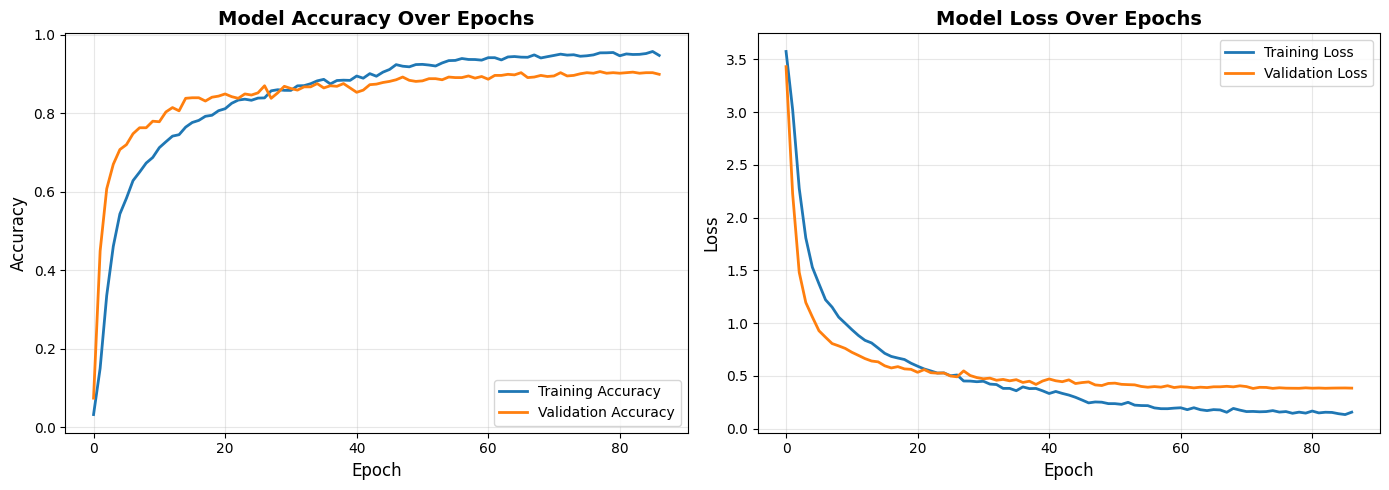


TRAININIG SUMMARY:
a. Best epoch: 78
b. Best training accuracy: 0.9533
c. Best validation accuracy: 0.9056
d. Total epochs trained: 87


In [93]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print best metrics
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = history.history['val_accuracy'][best_epoch]
    best_train_acc = history.history['accuracy'][best_epoch]
    
    print(f"\nTRAININIG SUMMARY:")
    print(f"a. Best epoch: {best_epoch + 1}")
    print(f"b. Best training accuracy: {best_train_acc:.4f}")
    print(f"c. Best validation accuracy: {best_val_acc:.4f}")
    print(f"d. Total epochs trained: {len(history.history['accuracy'])}")

plot_training_history(history)

SECTION 11: MODEL EVALUATION ON TEST SET

In [94]:
# Load best model that is saved by the check point
model = keras.models.load_model('best_asl_cnn_model.h5')
print("Loaded best model from checkpoint . . .")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)

print(f"\nTest Set Performance:")
print(f"a. Test Loss: {test_loss:.4f}")
print(f"b. Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

Loaded best model from checkpoint . . .

Test Set Performance:
a. Test Loss: 0.5320
b. Test Accuracy: 0.8847 (88.47%)


SECTION 12: MORE DETAILED METRICS

In [95]:
print("                  CLASSIFICATION REPORT:")
print("-" * 60)
report = classification_report(y_test, y_pred, target_names=CLASS_NAMES, digits=4)
print(report)

                  CLASSIFICATION REPORT:
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9524    1.0000    0.9756        20
           1     1.0000    1.0000    1.0000        20
           2     1.0000    1.0000    1.0000        20
           3     1.0000    1.0000    1.0000        20
           4     0.9524    1.0000    0.9756        20
           5     1.0000    0.9500    0.9744        20
           6     0.9524    1.0000    0.9756        20
           7     1.0000    1.0000    1.0000        20
           8     1.0000    1.0000    1.0000        20
           9     1.0000    1.0000    1.0000        20
           A     0.9444    0.8500    0.8947        20
           B     0.9048    0.9500    0.9268        20
           C     0.8000    0.8000    0.8000        20
           D     0.8095    0.8500    0.8293        20
           E     0.8182    0.9000    0.8571        20
           F     0.8571    0.9000

In [96]:
# Per-class accuracy
print("\n          PER-CLASS ACCURACY:")
print("-" * 40)
cm = confusion_matrix(y_test, y_pred)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

for i, class_name in enumerate(CLASS_NAMES):
    print(f"  {class_name}: {per_class_accuracy[i]:.4f} ({per_class_accuracy[i]*100:.2f}%)")


          PER-CLASS ACCURACY:
----------------------------------------
  0: 1.0000 (100.00%)
  1: 1.0000 (100.00%)
  2: 1.0000 (100.00%)
  3: 1.0000 (100.00%)
  4: 1.0000 (100.00%)
  5: 0.9500 (95.00%)
  6: 1.0000 (100.00%)
  7: 1.0000 (100.00%)
  8: 1.0000 (100.00%)
  9: 1.0000 (100.00%)
  A: 0.8500 (85.00%)
  B: 0.9500 (95.00%)
  C: 0.8000 (80.00%)
  D: 0.8500 (85.00%)
  E: 0.9000 (90.00%)
  F: 0.9000 (90.00%)
  G: 0.8000 (80.00%)
  H: 0.9500 (95.00%)
  I: 0.9000 (90.00%)
  J: 1.0000 (100.00%)
  K: 0.9000 (90.00%)
  L: 0.9500 (95.00%)
  M: 0.8500 (85.00%)
  N: 0.7500 (75.00%)
  O: 0.7000 (70.00%)
  P: 0.9000 (90.00%)
  Q: 0.8000 (80.00%)
  R: 0.8000 (80.00%)
  S: 0.6500 (65.00%)
  T: 0.6000 (60.00%)
  U: 0.8500 (85.00%)
  V: 0.9000 (90.00%)
  W: 0.8000 (80.00%)
  X: 0.7500 (75.00%)
  Y: 0.8000 (80.00%)
  Z: 1.0000 (100.00%)


SECTION 13: CONFUSION MATRIX

 CONFUSION MATRIX 


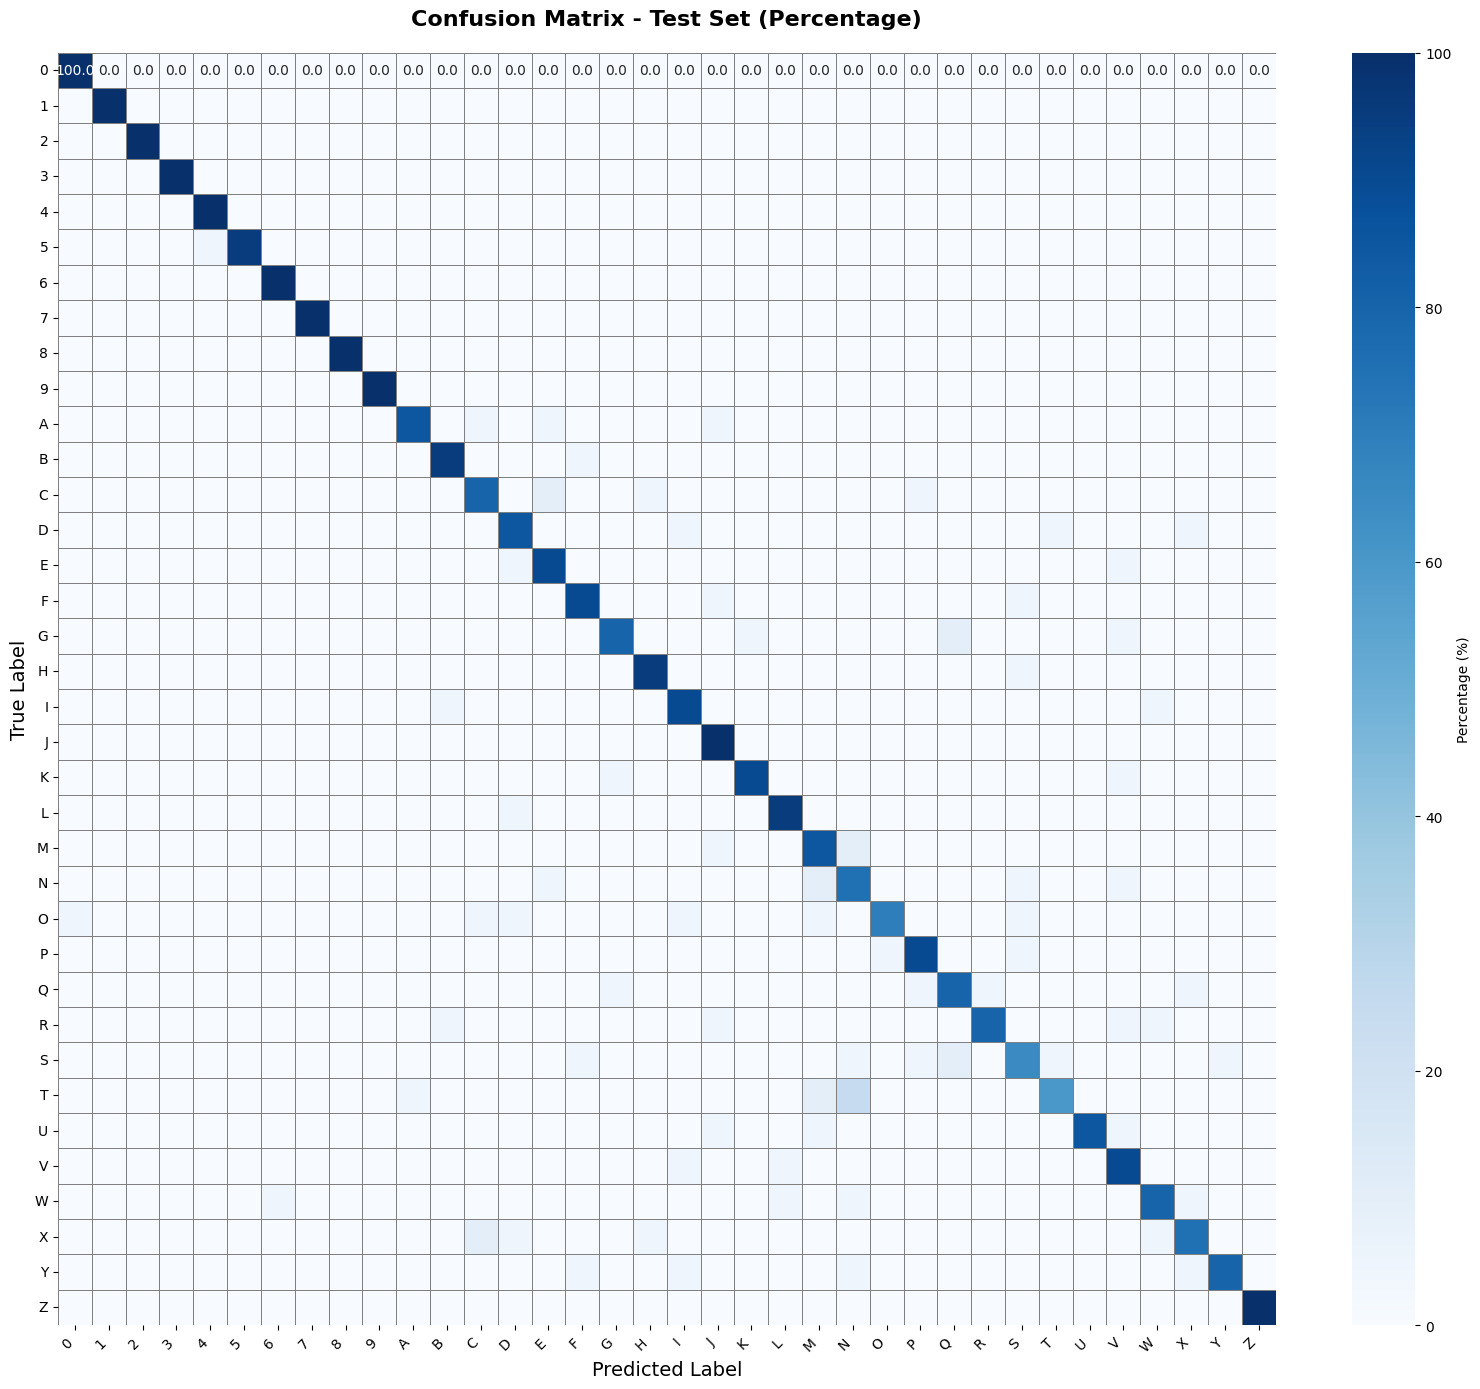


Confusion Matrix Insights:
a. Most confused pair: T → N (25.0%)
b. Lowest performing class: T (60.00%)
c. Average per-class accuracy: 88.47%


In [97]:
def plot_confusion_matrix_percentage(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    # Convert to percentages (row-wise)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create figure
    plt.figure(figsize=(16, 14))
    
    # Plot heatmap
    sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=class_names, 
                yticklabels=class_names, cbar_kws={'label': 'Percentage (%)'}, 
                linewidths=0.5, linecolor='gray')
    
    plt.title('Confusion Matrix - Test Set (Percentage)', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("\nConfusion Matrix Insights:")
    
    # Find most confused pairs
    np.fill_diagonal(cm_percentage, 0) #ignore the diagonal 
    most_confused_idx = np.unravel_index(cm_percentage.argmax(), cm_percentage.shape)
    most_confused_value = cm_percentage[most_confused_idx]
    
    print(f"a. Most confused pair: {class_names[most_confused_idx[0]]} → "f"{class_names[most_confused_idx[1]]} ({most_confused_value:.1f}%)")
    
    # Find classes with lowest accuracy
    cm_actual = confusion_matrix(y_true, y_pred)
    per_class_acc = cm_actual.diagonal() / cm_actual.sum(axis=1)
    worst_class_idx = np.argmin(per_class_acc)
    
    print(f"b. Lowest performing class: {class_names[worst_class_idx]} "f"({per_class_acc[worst_class_idx]*100:.2f}%)")
    
    # Average accuracy
    print(f"c. Average per-class accuracy: {per_class_acc.mean()*100:.2f}%")

print(" CONFUSION MATRIX ")

plot_confusion_matrix_percentage(y_test, y_pred, CLASS_NAMES)

SECTION 14: SAVE FINAL MODEL

In [98]:
print("SAVING MODEL . . .")

# Save final model
final_model_path = 'asl_final_cnn_model.h5'
model.save(final_model_path)
print(f"a. Final model saved to: {final_model_path}")

# Get predictions
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)
print("b. Training history saved to: training_history.csv")

SAVING MODEL . . .
a. Final model saved to: asl_final_cnn_model.h5
b. Training history saved to: training_history.csv
